In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
def preprocess_object_features():
    df_tr = pd.read_csv("../data/raw/training_v2.csv")

    df_train = df_tr.copy()

    # drop readmission_status as it has all 0
    df_train.drop('readmission_status', axis=1, inplace=True)
    df_train.drop('encounter_id', axis=1, inplace=True)
    df_train.drop('patient_id', axis=1, inplace=True)
    df_train.drop('hospital_id', axis=1, inplace=True)
    df_train.drop('icu_id', axis=1, inplace=True)

    # 25 genders are nan => replace them with 'M'
    df_train['gender'] = df_train['gender'].fillna(df_train['gender'].value_counts().index[0])
    df_train['gender'] = df_train['gender'].map({'M': 0, 'F': 1})
    
    df_train['ethnicity'] = df_train['ethnicity'].fillna("Other/Unknown")
        
    df_train['hospital_admit_source'] = df_train['hospital_admit_source'].fillna("Other")

    df_train['icu_stay_type'] = df_train['icu_stay_type'].fillna(df_train['icu_stay_type'].value_counts().index[0])
    df_train['icu_stay_type'] = df_train['icu_stay_type'].map({'admit': 0, 'transfer': 1})
    
    # remove outliers
    df_train = df_train[df_train["pre_icu_los_days"] < 88]
    df_train["pre_icu_los_days"] = np.maximum(0, df_train["pre_icu_los_days"])
    
    und_diag = {"Undefined diagnoses": "Undefined Diagnoses"}
    df_train["apache_2_bodysystem"].replace(und_diag, inplace = True)

    cat_columns = ["ethnicity", "hospital_admit_source",
                   "icu_admit_source", "icu_type",
                   "apache_3j_bodysystem", "apache_2_bodysystem"]

    df_train = pd.get_dummies(df_train, columns=cat_columns)

    df_train.fillna(df_train.mean(), inplace=True)

    return df_train

In [5]:
def evaluate(y_true, scores, preds):
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    
    roc_auc = roc_auc_score(y_true, scores)
    auprc = average_precision_score(y_true, scores)
    
    print("Accuracy:  {:.4f}".format(acc))
    print("Precision: {:.4f}".format(precision))
    print("Recall:    {:.4f}".format(recall))
    print("F1-score:  {:.4f}".format(f1))
    print("ROCAUC:    {:.4f}".format(roc_auc))
    print("AUPRC:     {:.4f}".format(auprc))

In [6]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
def plot_precision_recall_curve(y_test, probs):
    precision, recall, threshold = precision_recall_curve(y_test, probs)
    auc_score = auc(recall, precision)
    
    plt.title('2-class Precision-Recall curve')
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.plot(recall, precision, 'r', marker='.')
    plt.show()

In [8]:
clean_df = preprocess_object_features()

y = clean_df.hospital_death
X = clean_df.drop(columns="hospital_death")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

## Logistic Regression

In [9]:
weights = {0:1, 1:10}
lr_clf = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter=2000)
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
y_true = y_test.values

y_score = lr_clf.predict_proba(X_test)
y_pred = lr_clf.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.8161
Precision: 0.2872
Recall:    0.7626
F1-score:  0.4172
ROCAUC:    0.8801
AUPRC:     0.4950


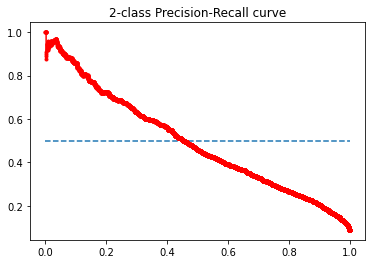

In [11]:
plot_precision_recall_curve(y_true, y_score[:, 1])

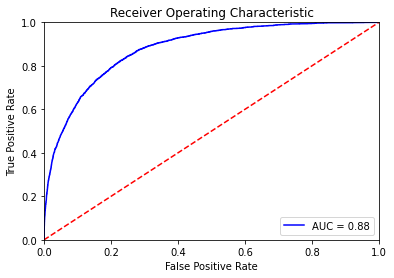

In [12]:
plot_roc_curve(y_true, y_score[:, 1])

## Decision Tree

In [13]:
weights = {0:1, 1:10}
dt_clf = DecisionTreeClassifier(class_weight=weights)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 10},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [14]:
y_true = y_test.values

y_score = dt_clf.predict_proba(X_test)
y_pred = dt_clf.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.8812
Precision: 0.3139
Recall:    0.3170
F1-score:  0.3154
ROCAUC:    0.6258
AUPRC:     0.1584


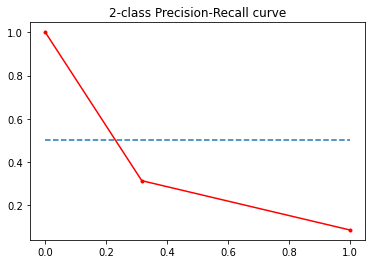

In [15]:
plot_precision_recall_curve(y_true, y_score[:, 1])

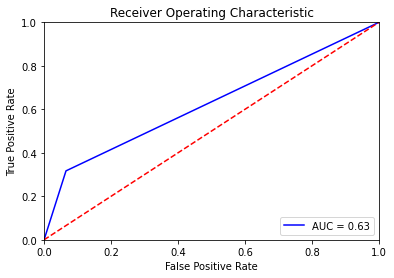

In [16]:
plot_roc_curve(y_true, y_score[:, 1])